In [7]:
%%capture
!apt-get update
!apt-get install --reinstall build-essential --yes

In [8]:
%%capture
!pip install bertopic==0.11.0
!pip install farm-haystack
!pip install spacy
!pip install gensim
!pip install sagemaker_pyspark
!python -m spacy download en_core_web_sm
!pip install joblib==1.1.0

In [9]:
%%capture
!pip install wordcloud

In [10]:
import re
import string
import pickle
import logging
import pandas as pd
import plotly.io as pio
import matplotlib.pyplot as plt
import gensim.corpora as corpora

from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from nltk.corpus import stopwords
from haystack.nodes import PreProcessor
from nltk.corpus import PlaintextCorpusReader
from haystack.utils import convert_files_to_docs
from sentence_transformers import SentenceTransformer
from gensim.models.coherencemodel import CoherenceModel

pio.renderers.default='iframe'
logging.getLogger("haystack.utils.preprocessing").setLevel(logging.ERROR)

In [11]:
import nltk

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('wordnet')
nltk.download('omw-1.4')
token_pattern = re.compile(r"(?u)\b\w\w+\b")
sentence_model = SentenceTransformer("all-distilroberta-v1")

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [
            self.wnl.lemmatize(t)
            for t in word_tokenize(doc)
            if (len(t) > 3 and re.match("[a-z].*", t) and re.match(token_pattern, t)) or (t=='ai')
        ]

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vedantgupta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/vedantgupta/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Visualizations

### 1950 - 1959

In [12]:
output = r"/Users/vedantgupta/Desktop/Oncampus - Research/nyt-topic-modeling-main/Topic Modeling Code/BERT/BERT/1950-1959/"

In [13]:
topic_model = BERTopic.load(output+"bert")
with open(output+'hierarchical_topics.pkl', 'rb') as f:
    hierarchical_topics = pickle.load(f)
with open(output+'docs.pkl', 'rb') as f:
    docs = pickle.load(f)
with open(output+'embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

#### Topic Representation

In [14]:
topic_model.get_topics()

{-1: [('automation', 0.016400661665563854),
  ('company', 0.01422853099987384),
  ('machine', 0.014079719579931324),
  ('industry', 0.013412870911536205),
  ('business', 0.01059027683970585),
  ('work', 0.009702977098492946),
  ('president', 0.009693359242894205),
  ('plant', 0.009669973317613503),
  ('many', 0.009465056793573283),
  ('worker', 0.009238793899604776)],
 0: [('union', 0.024247171078836616),
  ('labor', 0.022546251306160014),
  ('state', 0.019066829665627807),
  ('worker', 0.016767940290124083),
  ('president', 0.01615227666126577),
  ('economic', 0.01430784391883915),
  ('wage', 0.013487338824247458),
  ('program', 0.013432356728626828),
  ('work', 0.01295833556056691),
  ('industry', 0.012926618398087713)],
 1: [('company', 0.02993934157904709),
  ('share', 0.027047024947749236),
  ('stock', 0.024160916662953932),
  ('cent', 0.023395472829237214),
  ('fund', 0.021486930735619223),
  ('sale', 0.02102283823061296),
  ('yesterday', 0.015449753605177838),
  ('last', 0.01469

In [15]:
# listing all topics
for i in range(16):
    print("Topic "+ str(i-1) + ":")
    print()
    print("Representative Words:")
    print(topic_model.get_topic(i-1))
    print()
    print("Topic Info:")
    print(topic_model.get_topic_info(i-1))
    print()

Topic -1:

Representative Words:
[('automation', 0.016400661665563854), ('company', 0.01422853099987384), ('machine', 0.014079719579931324), ('industry', 0.013412870911536205), ('business', 0.01059027683970585), ('work', 0.009702977098492946), ('president', 0.009693359242894205), ('plant', 0.009669973317613503), ('many', 0.009465056793573283), ('worker', 0.009238793899604776)]

Topic Info:
   Topic  Count                                    Name
0     -1    270  -1_automation_company_machine_industry

Topic 0:

Representative Words:
[('union', 0.024247171078836616), ('labor', 0.022546251306160014), ('state', 0.019066829665627807), ('worker', 0.016767940290124083), ('president', 0.01615227666126577), ('economic', 0.01430784391883915), ('wage', 0.013487338824247458), ('program', 0.013432356728626828), ('work', 0.01295833556056691), ('industry', 0.012926618398087713)]

Topic Info:
    Topic  Count                                       Name
0      -1    270     -1_automation_company_machine

#### Visualize Topics

In [16]:
folder_path = r'/Users/vedantgupta/Desktop/Oncampus - Research/nyt-topic-modeling-main/Topic Modeling Code/BERT/BERT_FIGURES/'

In [18]:
# Topic distance map
fig = topic_model.visualize_topics()
fig.write_html(folder_path+'1950_1959/Intertopic_Distance_Map.html')

In [19]:
# representative words with probability for each topic
fig = topic_model.visualize_barchart(top_n_topics=15)
fig.write_html(folder_path+'1950_1959/Topic_Word_score.html')

In [21]:
fig = topic_model.visualize_documents(docs=docs, embeddings=embeddings)
fig.write_html(folder_path+'1950_1959/Docs_Topics.html')

In [22]:
#Applying TSNE to reduce embeddings
from sklearn.manifold import TSNE

reduced_embed = TSNE(n_components=10, learning_rate='auto', perplexity=30, method='exact').fit_transform(embeddings)

In [23]:
fig = topic_model.visualize_documents(docs=docs, embeddings=reduced_embed)
fig.write_html(folder_path+'1950_1959/Docs_Topics_TSNE.html')

In [24]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [25]:
def get_topic_word_cloud(topic_model, topic_number):
    word_freq = topic_model.get_topic(topic_number)
    word_freq = {w:f for w, f in word_freq}
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color='white')
    wordcloud.generate_from_frequencies(word_freq)
    wordcloud.to_file(folder_path+'Topic_'+str(topic_number)+'_wordclound.png')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Topic: -1


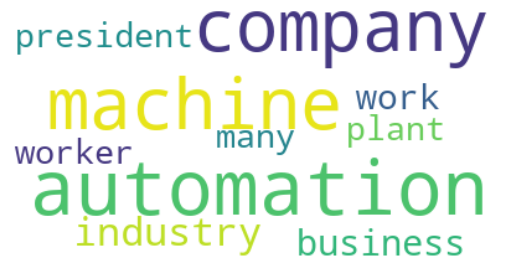

******************************
Topic: 0


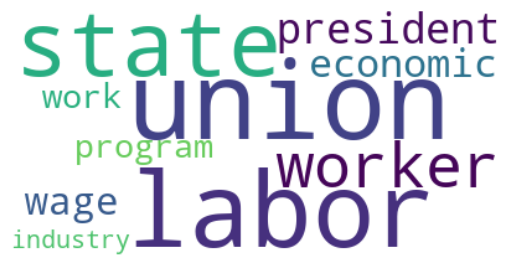

******************************
Topic: 1


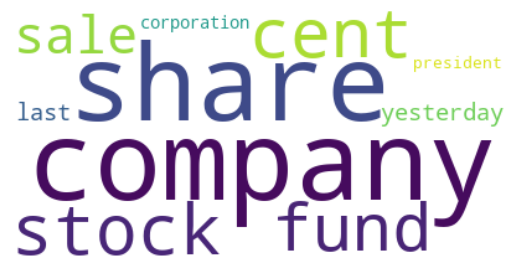

******************************
Topic: 2


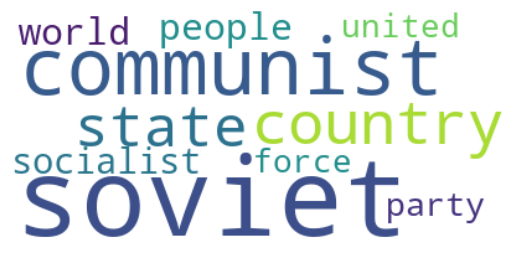

******************************
Topic: 3


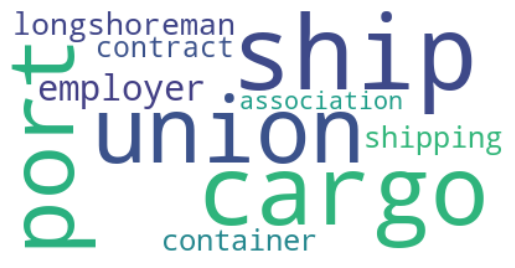

******************************
Topic: 4


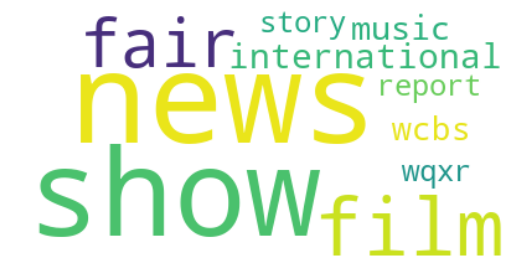

******************************
Topic: 5


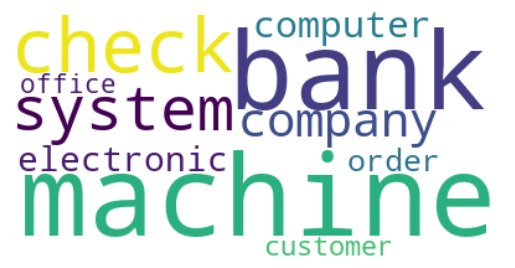

******************************
Topic: 6


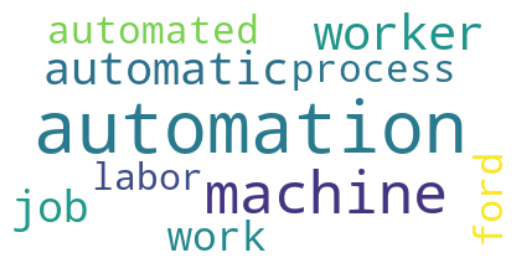

******************************
Topic: 7


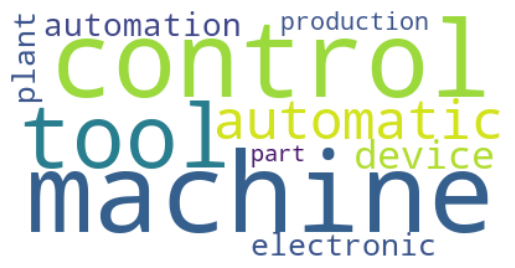

******************************
Topic: 8


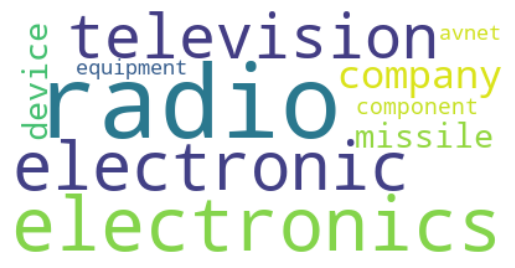

******************************
Topic: 9


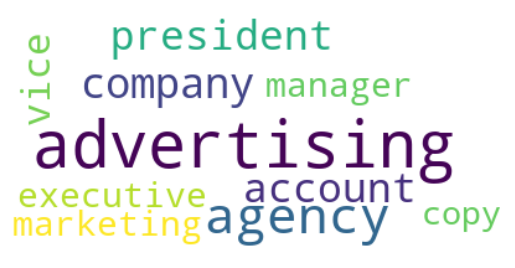

******************************
Topic: 10


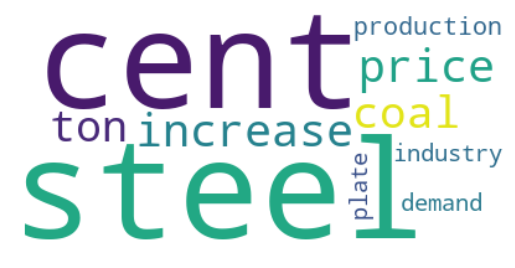

******************************
Topic: 11


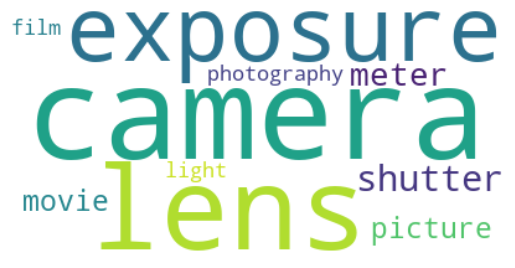

******************************
Topic: 12


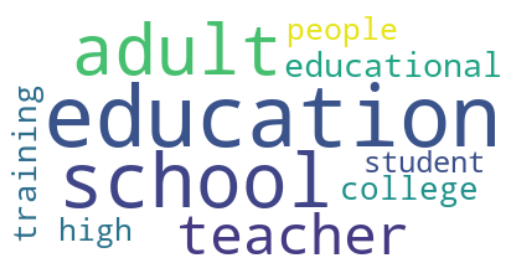

******************************
Topic: 13


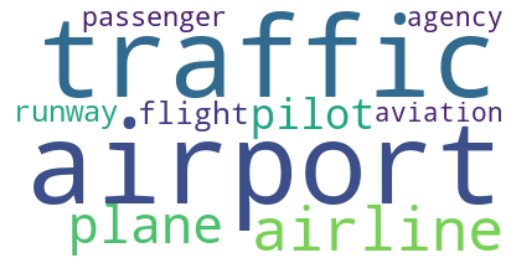

******************************
Topic: 14


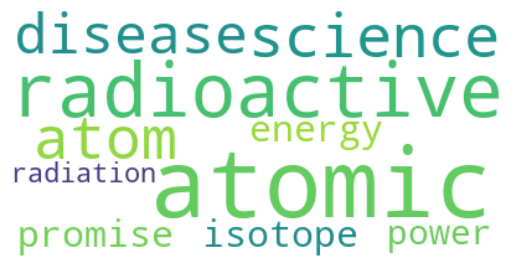

******************************


In [26]:
# word cloud for each topic
for i in range(16):
    print('Topic: ' + str(i-1))
    get_topic_word_cloud(topic_model, i-1)
    print('******************************')

In [28]:
# need embeddings
fig = topic_model.visualize_hierarchical_documents(docs, hierarchical_topics, embeddings=embeddings)
fig.write_html(folder_path+'1950_1959/Hierarchical_Docs_Topics.html')

In [30]:
# heirarchical topics
fig = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
fig.write_html(folder_path+'1950_1959/Hierarchical_Clustering.html')

In [31]:
# topic tree
tree = topic_model.get_topic_tree(hierarchical_topics)

In [32]:
print(tree)

.
├─company_state_union_industry_cent
│    ├─company_machine_share_automation_cent
│    │    ├─machine_automation_control_automatic_tool
│    │    │    ├─■──automation_machine_worker_automatic_job ── Topic: 6
│    │    │    └─■──machine_control_tool_automatic_device ── Topic: 7
│    │    └─company_share_cent_sale_stock
│    │         ├─■──radio_electronics_electronic_television_company ── Topic: 8
│    │         └─company_share_stock_cent_sale
│    │              ├─■──machine_bank_check_system_company ── Topic: 5
│    │              └─■──company_share_stock_cent_fund ── Topic: 1
│    └─union_state_soviet_labor_worker
│         ├─■──steel_cent_increase_price_coal ── Topic: 10
│         └─union_state_soviet_labor_people
│              ├─■──union_labor_state_worker_president ── Topic: 0
│              └─■──soviet_communist_country_state_people ── Topic: 2
└─advertising_film_show_news_international
     ├─advertising_news_show_international_york
     │    ├─news_show_film_education_school


In [33]:
# topic similarity
fig = topic_model.visualize_heatmap()
fig.write_html(folder_path+'1950_1959/Heatmap.html')

In [35]:
# if we keep adding words to topic name how score decreases
fig = topic_model.visualize_term_rank()
fig.write_html(folder_path+'1950_1959/Term_Score_decline.html')

In [36]:
fig = topic_model.visualize_term_rank(log_scale=True)
fig.write_html(folder_path+'1950_1959/Term_Score_decline_log_scale.html')

### 1960 - 1969

In [37]:
output = r"/Users/vedantgupta/Desktop/Oncampus - Research/nyt-topic-modeling-main/Topic Modeling Code/BERT/BERT/1960-1969/"

In [38]:
topic_model = BERTopic.load(output+"bert")
with open(output+'hierarchical_topics.pkl', 'rb') as f:
    hierarchical_topics = pickle.load(f)
with open(output+'docs.pkl', 'rb') as f:
    docs = pickle.load(f)
with open(output+'embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

In [39]:
topic_model.get_topics()

{-1: [('state', 0.012609078813790737),
  ('president', 0.011250715954395486),
  ('cent', 0.011197468251883102),
  ('labor', 0.011109334293293978),
  ('company', 0.011087969900891413),
  ('automation', 0.010874240083269726),
  ('york', 0.010618248740137169),
  ('industry', 0.010588141724193128),
  ('program', 0.009868363916003221),
  ('worker', 0.009484806108267884)],
 0: [('labor', 0.02383029890076494),
  ('negro', 0.0179344420273302),
  ('union', 0.017132249615642775),
  ('worker', 0.016167851839401115),
  ('job', 0.015935138147212587),
  ('president', 0.015921124756888814),
  ('unemployment', 0.015796079366135002),
  ('automation', 0.013288270332953933),
  ('economic', 0.01322934068469094),
  ('program', 0.013021693223727836)],
 1: [('stock', 0.026982505816516757),
  ('company', 0.026768352713709174),
  ('share', 0.02585077145658882),
  ('exchange', 0.022469238051594103),
  ('sale', 0.019912613412657796),
  ('market', 0.017717025732706934),
  ('cent', 0.017203392673608982),
  ('indus

In [40]:
# listing all topics
for i in range(22):
    print("Topic "+ str(i-1) + ":")
    print()
    print("Representative Words:")
    print(topic_model.get_topic(i-1))
    print()
    print("Topic Info:")
    print(topic_model.get_topic_info(i-1))
    print()

Topic -1:

Representative Words:
[('state', 0.012609078813790737), ('president', 0.011250715954395486), ('cent', 0.011197468251883102), ('labor', 0.011109334293293978), ('company', 0.011087969900891413), ('automation', 0.010874240083269726), ('york', 0.010618248740137169), ('industry', 0.010588141724193128), ('program', 0.009868363916003221), ('worker', 0.009484806108267884)]

Topic Info:
   Topic  Count                           Name
0     -1    935  -1_state_president_cent_labor

Topic 0:

Representative Words:
[('labor', 0.02383029890076494), ('negro', 0.0179344420273302), ('union', 0.017132249615642775), ('worker', 0.016167851839401115), ('job', 0.015935138147212587), ('president', 0.015921124756888814), ('unemployment', 0.015796079366135002), ('automation', 0.013288270332953933), ('economic', 0.01322934068469094), ('program', 0.013021693223727836)]

Topic Info:
    Topic  Count                                       Name
0      -1    935              -1_state_president_cent_labor
1

#### Visualize Topics

In [41]:
# Topic distance map
fig = topic_model.visualize_topics()
fig.write_html(folder_path+'1960_1969/Intertopic_Distance_Map.html')

In [42]:
# representative words with probability for each topic
fig = topic_model.visualize_barchart(top_n_topics=21)
fig.write_html(folder_path+'1960_1969/Topic_Word_score.html')

In [44]:
fig = topic_model.visualize_documents(docs=docs, embeddings=embeddings)
fig.write_html(folder_path+'1960_1969/Docs_Topics.html')

In [45]:
#Applying TSNE to reduce embeddings
from sklearn.manifold import TSNE

reduced_embed = TSNE(n_components=10, learning_rate='auto', perplexity=30, method='exact').fit_transform(embeddings)

In [46]:
fig = topic_model.visualize_documents(docs=docs, embeddings=reduced_embed)
fig.write_html(folder_path+'1960_1969/Docs_Topics_TSNE.html')

In [47]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [48]:
def get_topic_word_cloud(topic_model, topic_number):
    word_freq = topic_model.get_topic(topic_number)
    word_freq = {w:f for w, f in word_freq}
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color='white')
    wordcloud.generate_from_frequencies(word_freq)
    wordcloud.to_file(folder_path+'Topic_'+str(topic_number)+'_wordclound.png')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Topic: -1


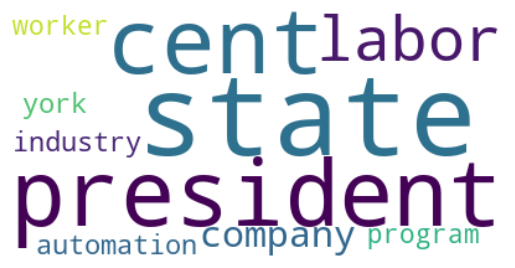

******************************
Topic: 0


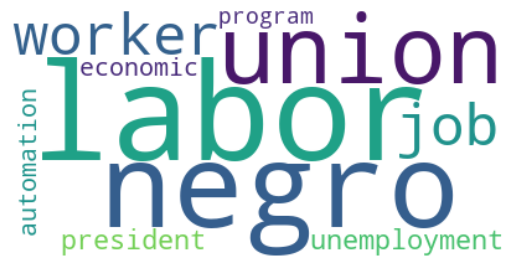

******************************
Topic: 1


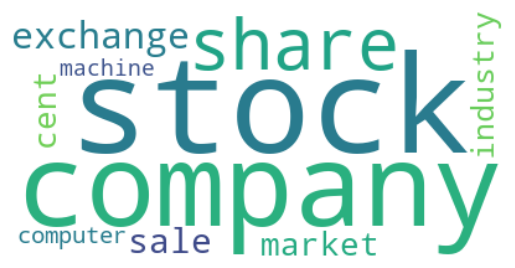

******************************
Topic: 2


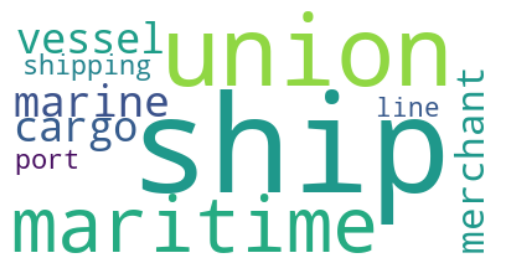

******************************
Topic: 3


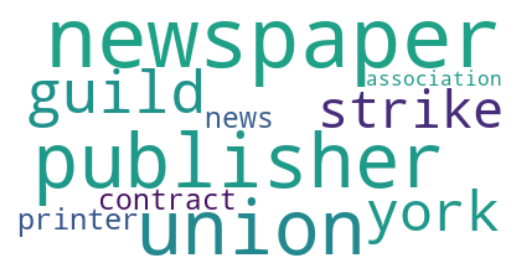

******************************
Topic: 4


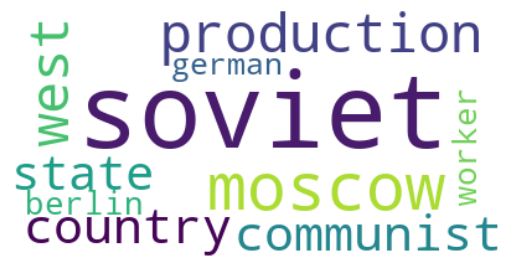

******************************
Topic: 5


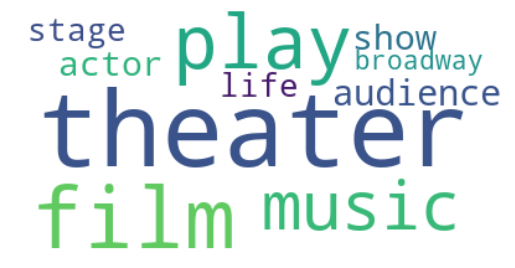

******************************
Topic: 6


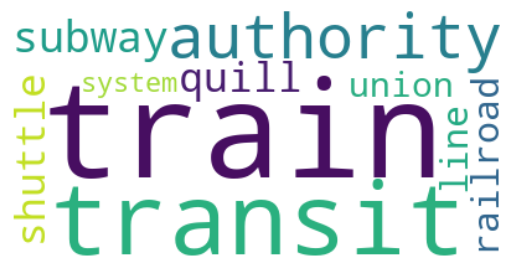

******************************
Topic: 7


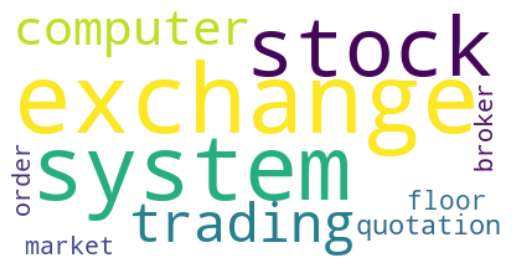

******************************
Topic: 8


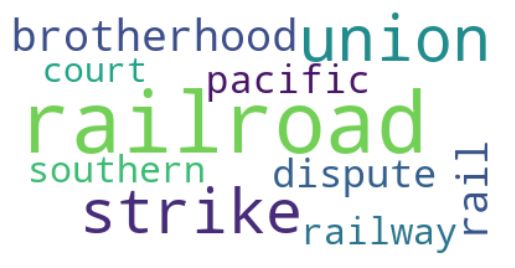

******************************
Topic: 9


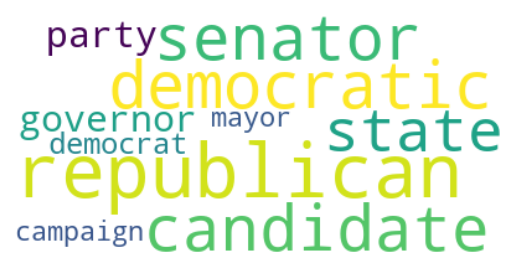

******************************
Topic: 10


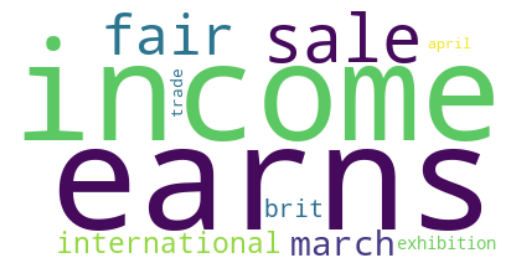

******************************
Topic: 11


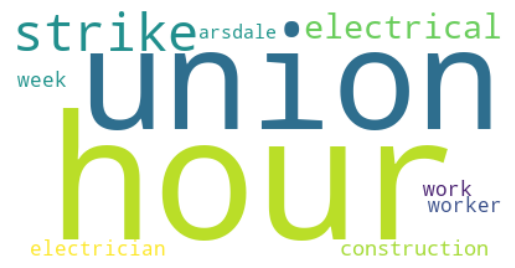

******************************
Topic: 12


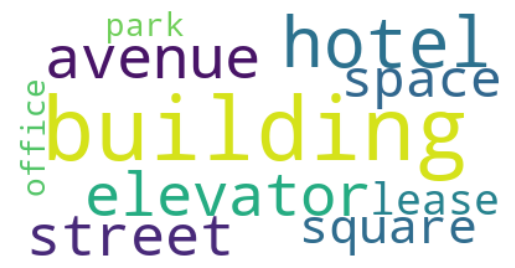

******************************
Topic: 13


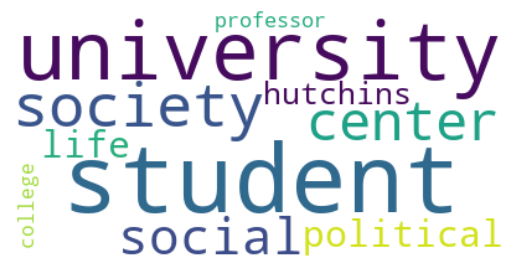

******************************
Topic: 14


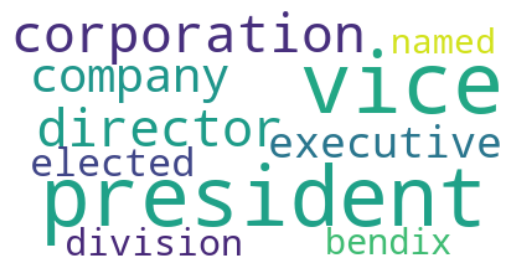

******************************
Topic: 15


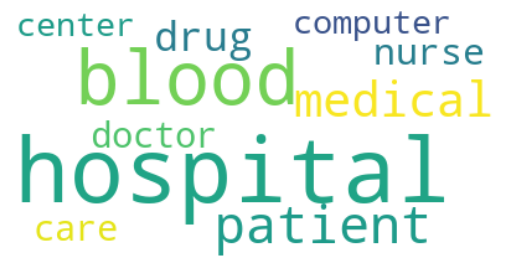

******************************
Topic: 16


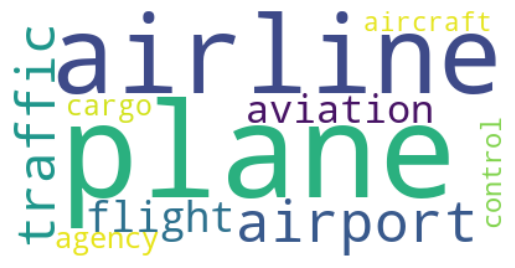

******************************
Topic: 17


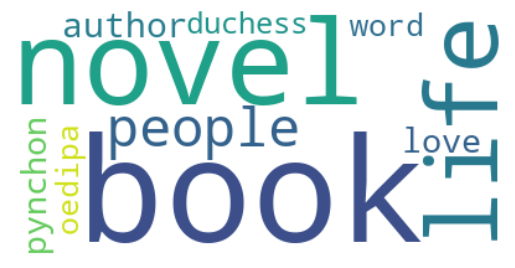

******************************
Topic: 18


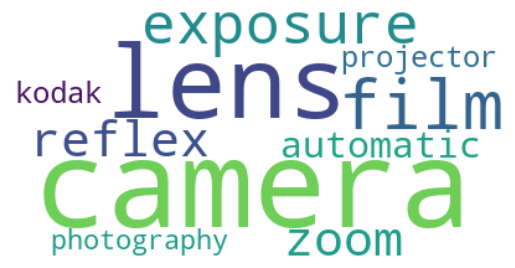

******************************
Topic: 19


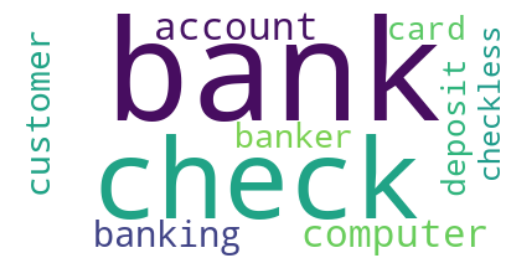

******************************
Topic: 20


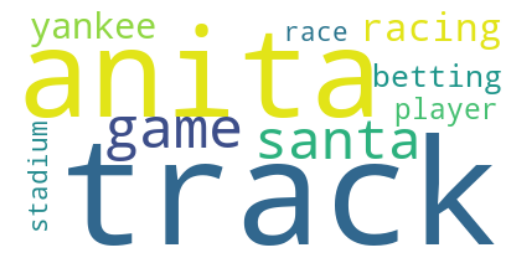

******************************


In [49]:
# word cloud for each topic
for i in range(22):
    print('Topic: ' + str(i-1))
    get_topic_word_cloud(topic_model, i-1)
    print('******************************')

In [51]:
# need embeddings
fig = topic_model.visualize_hierarchical_documents(docs, hierarchical_topics, embeddings=embeddings)
fig.write_html(folder_path+'1960_1969/hierarchical_Docs_Topics.html')

In [53]:
# heirarchical topics
fig = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
fig.write_html(folder_path+'1960_1969/Hierarchical_Clustering.html')

In [54]:
# topic tree
tree = topic_model.get_topic_tree(hierarchical_topics)

In [55]:
print(tree)

.
├─union_labor_strike_automation_president
│    ├─union_newspaper_ship_strike_contract
│    │    ├─■──train_transit_authority_subway_quill ── Topic: 6
│    │    └─union_newspaper_ship_strike_publisher
│    │         ├─newspaper_union_publisher_strike_guild
│    │         │    ├─newspaper_union_publisher_guild_york
│    │         │    │    ├─■──newspaper_publisher_union_guild_york ── Topic: 3
│    │         │    │    └─■──hour_union_strike_electrical_construction ── Topic: 11
│    │         │    └─■──railroad_union_strike_brotherhood_rail ── Topic: 8
│    │         └─■──ship_union_maritime_marine_vessel ── Topic: 2
│    └─labor_worker_union_president_negro
│         ├─labor_union_worker_negro_president
│         │    ├─labor_union_worker_negro_job
│         │    │    ├─■──labor_negro_union_worker_job ── Topic: 0
│         │    │    └─■──soviet_moscow_production_west_country ── Topic: 4
│         │    └─■──student_university_society_center_social ── Topic: 13
│         └─■──republican_d

In [56]:
# topic similarity
fig = topic_model.visualize_heatmap()
fig.write_html(folder_path+'1960_1969/Heatmap.html')

In [58]:
# if we keep adding words to topic name how score decreases
fig = topic_model.visualize_term_rank()
fig.write_html(folder_path+'1960_1969/Term_Score_Decline.html')

In [59]:
fig = topic_model.visualize_term_rank(log_scale=True)
fig.write_html(folder_path+'1960_1969/Term_Score_Decline_log_scale.html')

### 1970 - 1979

In [89]:
output = r"/Users/vedantgupta/Desktop/Oncampus - Research/nyt-topic-modeling-main/Topic Modeling Code/BERT/BERT/1970-1979/"

In [90]:
topic_model = BERTopic.load(output+"bert")
with open(output+'hierarchical_topics.pkl', 'rb') as f:
    hierarchical_topics = pickle.load(f)
with open(output+'docs.pkl', 'rb') as f:
    docs = pickle.load(f)
with open(output+'embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

In [91]:
topic_model.get_topics()

{-1: [('income', 0.028341734557743508),
  ('earns', 0.02682436899677915),
  ('sale', 0.023509812541112316),
  ('union', 0.01700623006211997),
  ('company', 0.016916501901212837),
  ('share', 0.016534196556262662),
  ('york', 0.01635837011818444),
  ('cent', 0.0150887203289035),
  ('million', 0.01419244905539711),
  ('industry', 0.013489198388354998)],
 0: [('union', 0.020310838554009645),
  ('work', 0.015066976702028717),
  ('state', 0.014343786514570035),
  ('labor', 0.014125456846154216),
  ('american', 0.01406877056945443),
  ('worker', 0.014042256626102312),
  ('people', 0.013628599913706253),
  ('york', 0.013379749688136678),
  ('city', 0.013348150294899514),
  ('school', 0.011982098198218818)],
 1: [('exchange', 0.06557861997312474),
  ('stock', 0.06150669692982847),
  ('company', 0.049851742665189144),
  ('market', 0.04331212297746437),
  ('income', 0.03051319583238082),
  ('corporation', 0.029659003595133616),
  ('earns', 0.02891810387875674),
  ('share', 0.028033650704180336),

In [92]:
# listing all topics
for i in range(5):
    print("Topic "+ str(i-1) + ":")
    print()
    print("Representative Words:")
    print(topic_model.get_topic(i-1))
    print()
    print("Topic Info:")
    print(topic_model.get_topic_info(i-1))
    print()

Topic -1:

Representative Words:
[('income', 0.028341734557743508), ('earns', 0.02682436899677915), ('sale', 0.023509812541112316), ('union', 0.01700623006211997), ('company', 0.016916501901212837), ('share', 0.016534196556262662), ('york', 0.01635837011818444), ('cent', 0.0150887203289035), ('million', 0.01419244905539711), ('industry', 0.013489198388354998)]

Topic Info:
   Topic  Count                        Name
0     -1   2715  -1_income_earns_sale_union

Topic 0:

Representative Words:
[('union', 0.020310838554009645), ('work', 0.015066976702028717), ('state', 0.014343786514570035), ('labor', 0.014125456846154216), ('american', 0.01406877056945443), ('worker', 0.014042256626102312), ('people', 0.013628599913706253), ('york', 0.013379749688136678), ('city', 0.013348150294899514), ('school', 0.011982098198218818)]

Topic Info:
   Topic  Count                             Name
0     -1   2715       -1_income_earns_sale_union
1      0    516         0_union_work_state_labor
2      1  

In [93]:
# Topic distance map
fig = topic_model.visualize_topics()
fig.write_html(folder_path+'1970_1979/Intertopic_Distance_Map.html')

In [94]:
# representative words with probability for each topic
fig = topic_model.visualize_barchart(top_n_topics=5)
fig.write_html(folder_path+'1970_1979/Topic_Word_Scores.html')

In [68]:
fig = topic_model.visualize_documents(docs=docs, embeddings=embeddings)
fig.write_html(folder_path+'1970_1979/Docs_Topics.html')

In [69]:
#Applying TSNE to reduce embeddings
from sklearn.manifold import TSNE

reduced_embed = TSNE(n_components=10, learning_rate='auto', perplexity=30, method='exact').fit_transform(embeddings)

In [70]:
fig = topic_model.visualize_documents(docs=docs, embeddings=reduced_embed)
fig.write_html(folder_path+'1970_1979/Docs_Topics_TSNE.html')

In [71]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def get_topic_word_cloud(topic_model, topic_number):
    word_freq = topic_model.get_topic(topic_number)
    word_freq = {w:f for w, f in word_freq}
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color='white')
    wordcloud.generate_from_frequencies(word_freq)
    wordcloud.to_file(folder_path+'Topic_'+str(topic_number)+'_wordclound.png')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Topic: -1


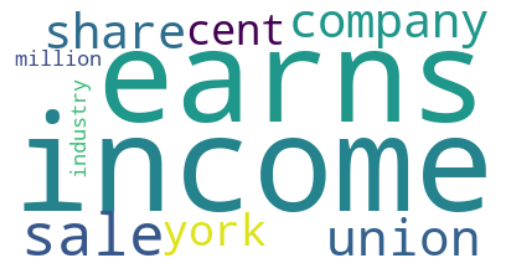

******************************
Topic: 0


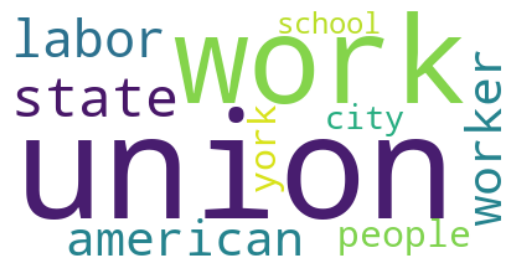

******************************
Topic: 1


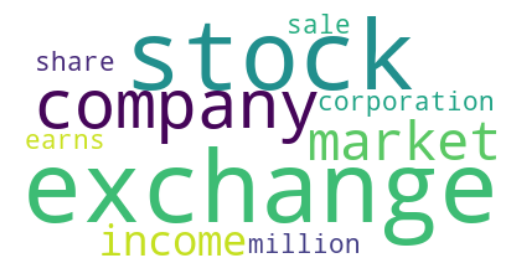

******************************
Topic: 2


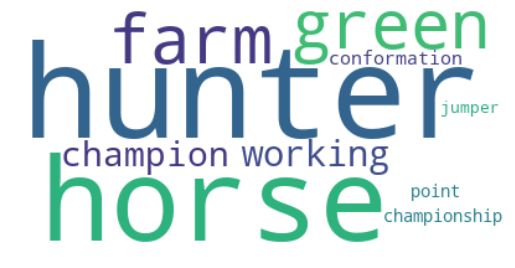

******************************
Topic: 3


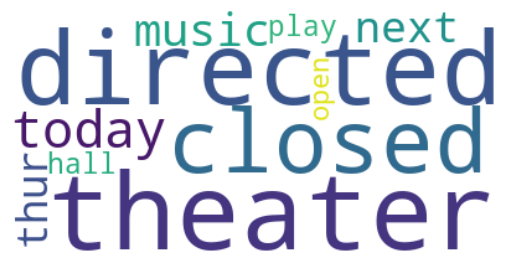

******************************


In [72]:
# word cloud for each topic
for i in range(5):
    print('Topic: ' + str(i-1))
    get_topic_word_cloud(topic_model, i-1)
    print('******************************')

In [74]:
# heirarchical topics
fig = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
fig.write_html(folder_path+'1970_1979/Hierarchical_Clustering.html')

In [75]:
# topic tree
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

.
├─■──hunter_horse_farm_green_working ── Topic: 2
└─company_york_american_theater_exchange
     ├─■──theater_directed_closed_today_music ── Topic: 3
     └─company_exchange_stock_york_market
          ├─■──union_work_state_labor_american ── Topic: 0
          └─■──exchange_stock_company_market_income ── Topic: 1



In [76]:
# topic similarity
fig = topic_model.visualize_heatmap()
fig.write_html(folder_path+'1970_1979/Heatmap.html')

In [78]:
# if we keep adding words to topic name how score decreases
fig = topic_model.visualize_term_rank()
fig.write_html(folder_path+'1970_1979/Topic_Score_decline.html')

In [79]:
fig = topic_model.visualize_term_rank(log_scale=True)
fig.write_html(folder_path+'1970_1979/Topic_Score_decline_log_scale.html')

### 1980 - 1989

In [80]:
output = r"/Users/vedantgupta/Desktop/Oncampus - Research/nyt-topic-modeling-main/Topic Modeling Code/BERT/BERT/1980-1989/"

In [81]:
topic_model = BERTopic.load(output+"bert")
with open(output+'hierarchical_topics.pkl', 'rb') as f:
    hierarchical_topics = pickle.load(f)
with open(output+'docs.pkl', 'rb') as f:
    docs = pickle.load(f)
with open(output+'embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

In [82]:
topic_model.get_topics()

{-1: [('university', 0.11918323302826818),
  ('father', 0.11455366076031365),
  ('graduated', 0.08976704164645949),
  ('york', 0.08911572979301169),
  ('daughter', 0.08886039095290203),
  ('bride', 0.07578248487866718),
  ('married', 0.06600517768122022),
  ('school', 0.057429153372147386),
  ('degree', 0.056786999016855404),
  ('rabbi', 0.05646555977049383)],
 0: [('company', 0.03298654829452128),
  ('computer', 0.020793691449488446),
  ('percent', 0.01830429892526068),
  ('system', 0.017739137930844678),
  ('million', 0.017396717656660978),
  ('industry', 0.016947126375191773),
  ('worker', 0.01520598727541383),
  ('market', 0.015152566663903978),
  ('business', 0.01485242686662123),
  ('state', 0.014031438711881348)],
 1: [('earns', 0.3904046426578056),
  ('report', 0.2893298658361894),
  ('share', 0.27504914059164554),
  ('automation', 0.2106004992816891),
  ('company', 0.17834721774847262),
  ('extraordinary', 0.15784862040276282),
  ('quarter', 0.14467839039466812),
  ('loss', 0.

In [83]:
# listing all topics
for i in range(len(topic_model.get_topics())+1):
    print("Topic "+ str(i-1) + ":")
    print()
    print("Representative Words:")
    print(topic_model.get_topic(i-1))
    print()
    print("Topic Info:")
    print(topic_model.get_topic_info(i-1))
    print()

Topic -1:

Representative Words:
[('university', 0.11918323302826818), ('father', 0.11455366076031365), ('graduated', 0.08976704164645949), ('york', 0.08911572979301169), ('daughter', 0.08886039095290203), ('bride', 0.07578248487866718), ('married', 0.06600517768122022), ('school', 0.057429153372147386), ('degree', 0.056786999016855404), ('rabbi', 0.05646555977049383)]

Topic Info:
   Topic  Count                                 Name
0     -1     27  -1_university_father_graduated_york

Topic 0:

Representative Words:
[('company', 0.03298654829452128), ('computer', 0.020793691449488446), ('percent', 0.01830429892526068), ('system', 0.017739137930844678), ('million', 0.017396717656660978), ('industry', 0.016947126375191773), ('worker', 0.01520598727541383), ('market', 0.015152566663903978), ('business', 0.01485242686662123), ('state', 0.014031438711881348)]

Topic Info:
   Topic  Count                                 Name
0     -1     27  -1_university_father_graduated_york
1      0   1

In [88]:
# Topic distance map
fig = topic_model.visualize_topics()
fig.write_html(folder_path+'1980_1989/Intertopic_Distance_Map.html')

In [87]:
# representative words with probability for each topic
fig = topic_model.visualize_barchart(top_n_topics=len(topic_model.get_topics()))
fig.write_html(folder_path+'1980_1989/Topic_Word_Score.html')

In [96]:
fig = topic_model.visualize_documents(docs=docs, embeddings=embeddings)
fig.write_html(folder_path+'1980_1989/Docs_Topics.html')

In [97]:
#Applying TSNE to reduce embeddings
from sklearn.manifold import TSNE

reduced_embed = TSNE(n_components=10, learning_rate='auto', perplexity=30, method='exact').fit_transform(embeddings)

In [98]:
fig = topic_model.visualize_documents(docs=docs, embeddings=reduced_embed)
fig.write_html(folder_path+'1980_1989/Docs_Topics_TSNE.html')

In [99]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def get_topic_word_cloud(topic_model, topic_number):
    word_freq = topic_model.get_topic(topic_number)
    word_freq = {w:f for w, f in word_freq}
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color='white')
    wordcloud.generate_from_frequencies(word_freq)
    wordcloud.to_file(folder_path+'Topic_'+str(topic_number)+'_wordclound.png')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Topic: -1


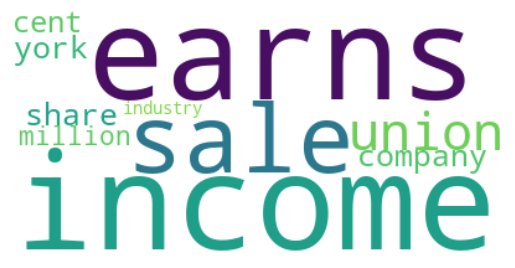

******************************
Topic: 0


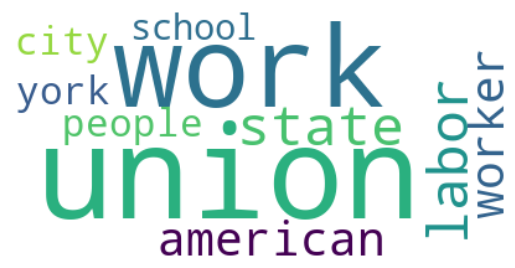

******************************
Topic: 1


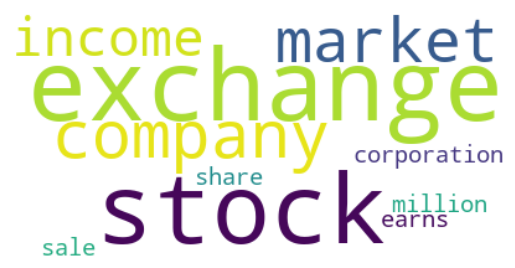

******************************
Topic: 2


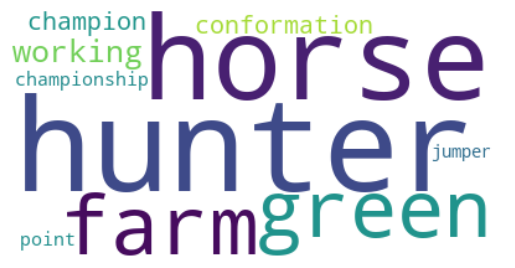

******************************
Topic: 3


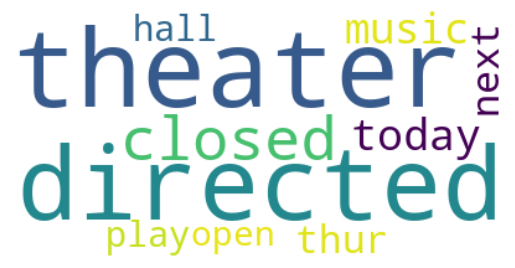

******************************


In [100]:
# word cloud for each topic
for i in range(len(topic_model.get_topics())):
    print('Topic: ' + str(i-1))
    get_topic_word_cloud(topic_model, i-1)
    print('******************************')

In [101]:
# heirarchical topics
fig = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
fig.write_html(folder_path+'1980_1989/Hierarchical_Clustering.html')

In [74]:
# topic tree
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

.
├─■──earns_report_share_automation_company ── Topic: 1
└─company_computer_system_percent_million
     ├─company_computer_system_percent_million
     │    ├─■──president_vice_named_chief_executive ── Topic: 2
     │    └─company_computer_system_percent_million
     │         ├─■──company_computer_percent_system_million ── Topic: 0
     │         └─■──airline_pilot_plane_flight_system ── Topic: 3
     └─■──camera_lens_exposure_film_shutter ── Topic: 4



In [102]:
# topic similarity
fig = topic_model.visualize_heatmap()
fig.write_html(folder_path+'1980_1989/Heatmap.html')

In [103]:
# if we keep adding words to topic name how score decreases
fig = topic_model.visualize_term_rank()
fig.write_html(folder_path+'1980_1989/Topic_Score_decline.html')

In [104]:
topic_model.visualize_term_rank(log_scale=True)
fig.write_html(folder_path+'1980_1989/Topic_Score_decline_log_scale.html')

### 1990 - 1999

In [105]:
output = r"/Users/vedantgupta/Desktop/Oncampus - Research/nyt-topic-modeling-main/Topic Modeling Code/BERT/BERT/1990-1999/"

In [106]:
topic_model = BERTopic.load(output+"bert")
with open(output+'hierarchical_topics.pkl', 'rb') as f:
    hierarchical_topics = pickle.load(f)
with open(output+'docs.pkl', 'rb') as f:
    docs = pickle.load(f)
with open(output+'embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

In [107]:
topic_model.get_topics()

{-1: [('tech', 0.06159017063043844),
  ('pilot', 0.04088265448896611),
  ('short', 0.036545491809334515),
  ('captain', 0.029510567157790848),
  ('bncp', 0.02888699672906347),
  ('medical', 0.028523541108070413),
  ('commun', 0.0283787162460156),
  ('system', 0.028269329109505394),
  ('bancorp', 0.024503536814619205),
  ('plane', 0.023654123359015265)],
 0: [('company', 0.028366858768707728),
  ('computer', 0.01747047457771637),
  ('million', 0.017289272576944494),
  ('percent', 0.01624491736880876),
  ('system', 0.01604365044362283),
  ('people', 0.01449705888469802),
  ('business', 0.014068091605122336),
  ('work', 0.013357980087419782),
  ('state', 0.013331873049889179),
  ('worker', 0.013053652395600763)],
 1: [('system', 0.06301373195347593),
  ('traffic', 0.04488521638813148),
  ('controller', 0.04219479107749474),
  ('airline', 0.04198318627442889),
  ('airport', 0.036408932453140745),
  ('control', 0.02989899663637997),
  ('agency', 0.024629311081523025),
  ('project', 0.020367

In [108]:
# listing all topics
for i in range(len(topic_model.get_topics())+1):
    print("Topic "+ str(i-1) + ":")
    print()
    print("Representative Words:")
    print(topic_model.get_topic(i-1))
    print()
    print("Topic Info:")
    print(topic_model.get_topic_info(i-1))
    print()

Topic -1:

Representative Words:
[('tech', 0.06159017063043844), ('pilot', 0.04088265448896611), ('short', 0.036545491809334515), ('captain', 0.029510567157790848), ('bncp', 0.02888699672906347), ('medical', 0.028523541108070413), ('commun', 0.0283787162460156), ('system', 0.028269329109505394), ('bancorp', 0.024503536814619205), ('plane', 0.023654123359015265)]

Topic Info:
   Topic  Count                         Name
0     -1     30  -1_tech_pilot_short_captain

Topic 0:

Representative Words:
[('company', 0.028366858768707728), ('computer', 0.01747047457771637), ('million', 0.017289272576944494), ('percent', 0.01624491736880876), ('system', 0.01604365044362283), ('people', 0.01449705888469802), ('business', 0.014068091605122336), ('work', 0.013357980087419782), ('state', 0.013331873049889179), ('worker', 0.013053652395600763)]

Topic Info:
   Topic  Count                                 Name
0     -1     30          -1_tech_pilot_short_captain
1      0   1156   0_company_computer_mi

In [110]:
# Topic distance map
fig = topic_model.visualize_topics()
fig.write_html(folder_path+'1990_1999/Intertopic_Distance_Map.html')

In [112]:
# representative words with probability for each topic
fig = topic_model.visualize_barchart(top_n_topics=len(topic_model.get_topics()))
fig.write_html(folder_path+'1990_1999/Topic_Word_score.html')

In [113]:
fig = topic_model.visualize_documents(docs=docs, embeddings=embeddings)
fig.write_html(folder_path+'1990_1999/Docs_Topics.html')

In [114]:
#Applying TSNE to reduce embeddings
from sklearn.manifold import TSNE

reduced_embed = TSNE(n_components=10, learning_rate='auto', perplexity=30, method='exact').fit_transform(embeddings)

In [115]:
fig = topic_model.visualize_documents(docs=docs, embeddings=reduced_embed)
fig.write_html(folder_path+'1990_1999/Docs_Topics_TSNE.html')

In [116]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def get_topic_word_cloud(topic_model, topic_number):
    word_freq = topic_model.get_topic(topic_number)
    word_freq = {w:f for w, f in word_freq}
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color='white')
    wordcloud.generate_from_frequencies(word_freq)
    wordcloud.to_file(folder_path+'Topic_'+str(topic_number)+'_wordclound.png')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Topic: -1


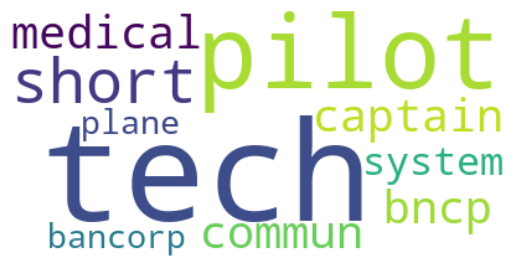

******************************
Topic: 0


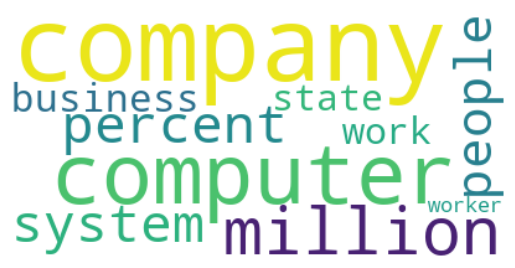

******************************
Topic: 1


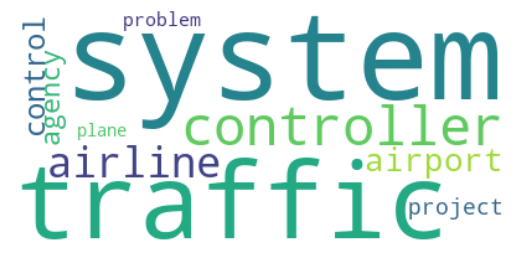

******************************
Topic: 2


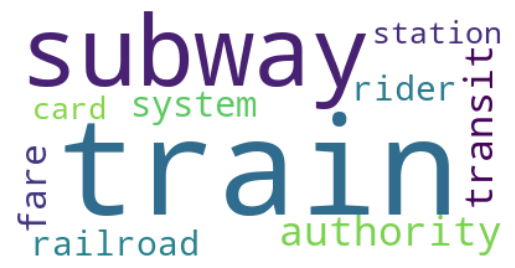

******************************
Topic: 3


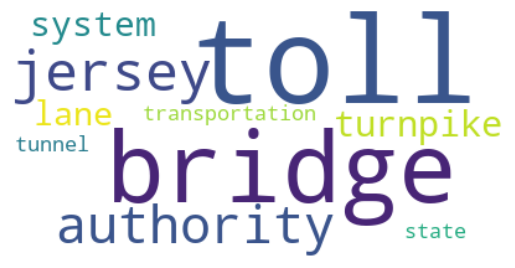

******************************
Topic: 4


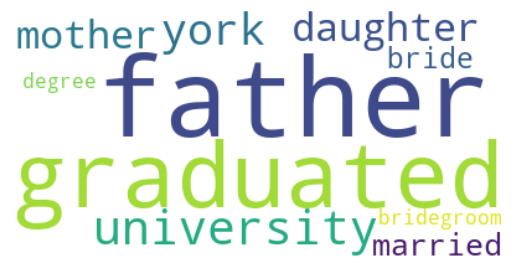

******************************


In [117]:
# word cloud for each topic
for i in range(len(topic_model.get_topics())):
    print('Topic: ' + str(i-1))
    get_topic_word_cloud(topic_model, i-1)
    print('******************************')

In [118]:
# heirarchical topics
fig = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
fig.write_html(folder_path+'1990_1999/Hierarchical_Clustering.html')

In [91]:
# topic tree
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

.
├─■──father_graduated_university_york_daughter ── Topic: 4
└─company_system_computer_million_percent
     ├─company_system_computer_million_percent
     │    ├─■──system_traffic_controller_airline_airport ── Topic: 1
     │    └─■──company_computer_million_percent_system ── Topic: 0
     └─toll_authority_system_bridge_train
          ├─■──train_subway_authority_transit_fare ── Topic: 2
          └─■──toll_bridge_jersey_authority_turnpike ── Topic: 3



In [119]:
# topic similarity
fig = topic_model.visualize_heatmap()
fig.write_html(folder_path+'1990_1999/Heatmap.html')

In [121]:
# if we keep adding words to topic name how score decreases
fig = topic_model.visualize_term_rank()
fig.write_html(folder_path+'1990_1999/Term_Score_Decline.html')

In [122]:
fig = topic_model.visualize_term_rank(log_scale=True)
fig.write_html(folder_path+'1990_1999/Term_Score_Decline_log_scale.html')

### 2000 - 2009

In [123]:
output = r"/Users/vedantgupta/Desktop/Oncampus - Research/nyt-topic-modeling-main/Topic Modeling Code/BERT/BERT/2000-2009/"

In [124]:
topic_model = BERTopic.load(output+"bert")
with open(output+'hierarchical_topics.pkl', 'rb') as f:
    hierarchical_topics = pickle.load(f)
with open(output+'docs.pkl', 'rb') as f:
    docs = pickle.load(f)
with open(output+'embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

In [125]:
topic_model.get_topics()

{-1: [('company', 0.014704283990670555),
  ('system', 0.010940463895005819),
  ('people', 0.010715195088416516),
  ('state', 0.010018077344127178),
  ('union', 0.00884970233171717),
  ('make', 0.008822712368248104),
  ('many', 0.008720968025943084),
  ('business', 0.008532173625050234),
  ('million', 0.008232950737344483),
  ('last', 0.008197622538198055)],
 0: [('company', 0.023566253313761578),
  ('software', 0.02172701407852252),
  ('system', 0.017673047790664823),
  ('home', 0.017238330769632007),
  ('computer', 0.01706902007239961),
  ('microsoft', 0.015995252196930602),
  ('service', 0.01522540689608559),
  ('technology', 0.014839362808144215),
  ('customer', 0.013477550818427797),
  ('percent', 0.012589185453848531)],
 1: [('airline', 0.020991873218106114),
  ('system', 0.013148788225303498),
  ('state', 0.012834952794216002),
  ('ticket', 0.01247986533366346),
  ('company', 0.01244472981292917),
  ('travel', 0.011610895715784175),
  ('york', 0.010747835213415319),
  ('city', 0.

In [126]:
# listing all topics
for i in range(len(topic_model.get_topics())+1):
    print("Topic "+ str(i-1) + ":")
    print()
    print("Representative Words:")
    print(topic_model.get_topic(i-1))
    print()
    print("Topic Info:")
    print(topic_model.get_topic_info(i-1))
    print()

Topic -1:

Representative Words:
[('company', 0.014704283990670555), ('system', 0.010940463895005819), ('people', 0.010715195088416516), ('state', 0.010018077344127178), ('union', 0.00884970233171717), ('make', 0.008822712368248104), ('many', 0.008720968025943084), ('business', 0.008532173625050234), ('million', 0.008232950737344483), ('last', 0.008197622538198055)]

Topic Info:
   Topic  Count                            Name
0     -1   1168  -1_company_system_people_state

Topic 0:

Representative Words:
[('company', 0.023566253313761578), ('software', 0.02172701407852252), ('system', 0.017673047790664823), ('home', 0.017238330769632007), ('computer', 0.01706902007239961), ('microsoft', 0.015995252196930602), ('service', 0.01522540689608559), ('technology', 0.014839362808144215), ('customer', 0.013477550818427797), ('percent', 0.012589185453848531)]

Topic Info:
    Topic  Count                                   Name
0      -1   1168         -1_company_system_people_state
1       0   

In [128]:
# Topic distance map
fig = topic_model.visualize_topics()
fig.write_html(folder_path+'2000_2009/Intertopic_Distance_Map.html')

In [129]:
# representative words with probability for each topic
fig = topic_model.visualize_barchart(top_n_topics=len(topic_model.get_topics()))
fig.write_html(folder_path+'2000_2009/Topic_Word_Score.html')

In [130]:
fig = topic_model.visualize_documents(docs=docs, embeddings=embeddings)
fig.write_html(folder_path+'2000_2009/Docs_Topics.html')

In [131]:
#Applying TSNE to reduce embeddings
from sklearn.manifold import TSNE

reduced_embed = TSNE(n_components=10, learning_rate='auto', perplexity=30, method='exact').fit_transform(embeddings)

In [139]:
fig = topic_model.visualize_documents(docs=docs, embeddings=reduced_embed)
fig.write_html(folder_path+'2000_2009/Docs_Topics_TSNE.html')

In [133]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def get_topic_word_cloud(topic_model, topic_number):
    word_freq = topic_model.get_topic(topic_number)
    word_freq = {w:f for w, f in word_freq}
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color='white')
    wordcloud.generate_from_frequencies(word_freq)
    wordcloud.to_file(folder_path+'Topic_'+str(topic_number)+'_wordclound.png')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Topic: -1


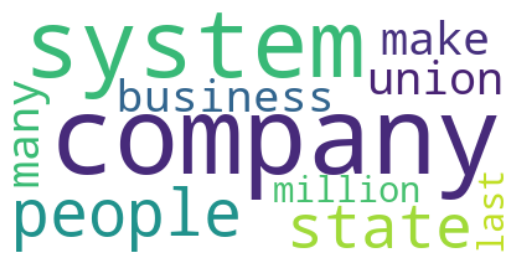

******************************
Topic: 0


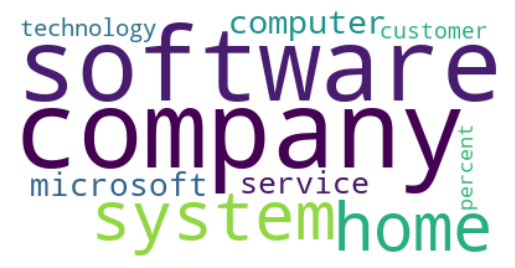

******************************
Topic: 1


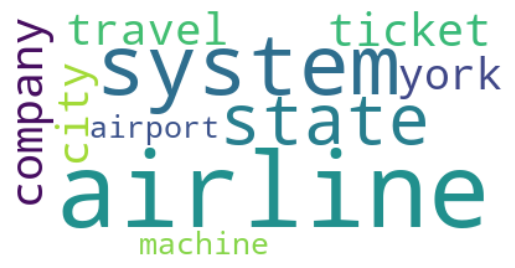

******************************
Topic: 2


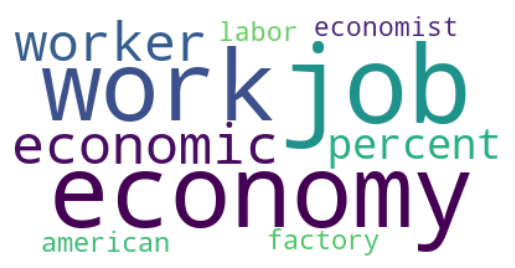

******************************
Topic: 3


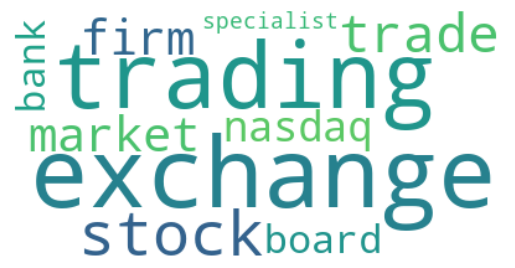

******************************
Topic: 4


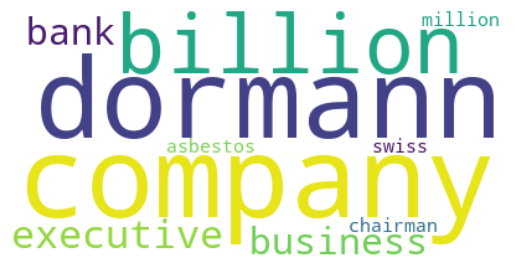

******************************
Topic: 5


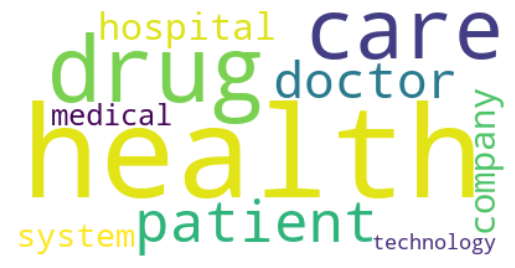

******************************
Topic: 6


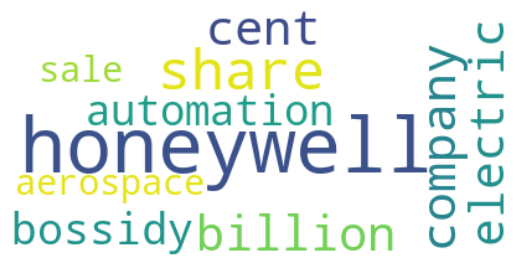

******************************
Topic: 7


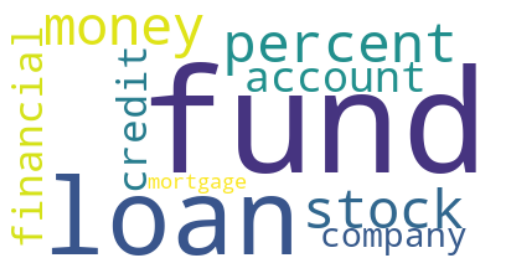

******************************
Topic: 8


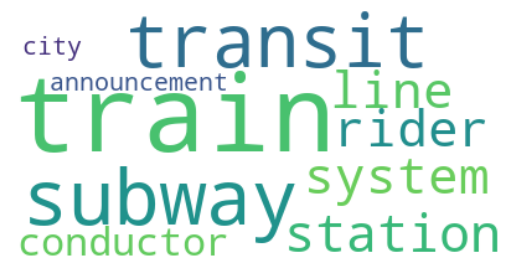

******************************
Topic: 9


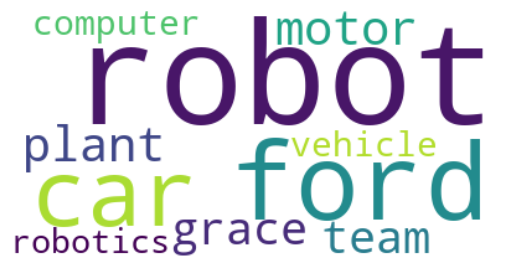

******************************
Topic: 10


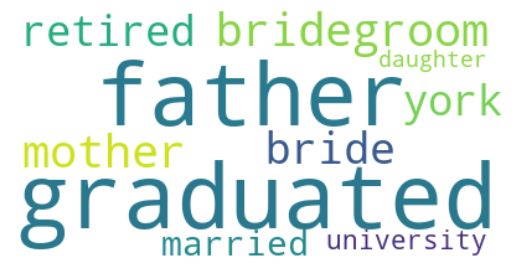

******************************
Topic: 11


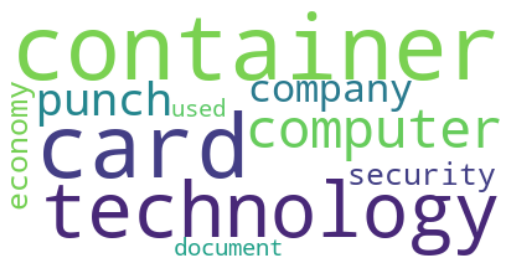

******************************
Topic: 12


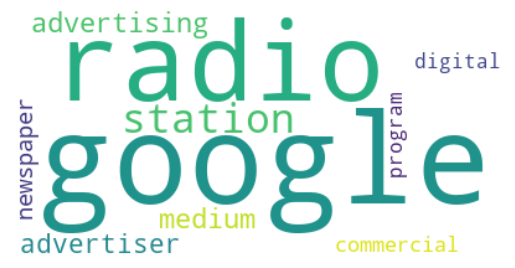

******************************
Topic: 13


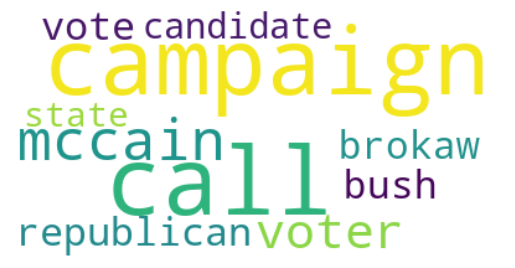

******************************
Topic: 14


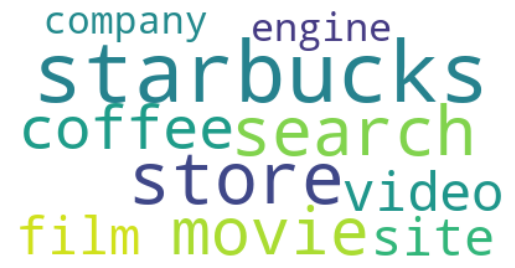

******************************
Topic: 15


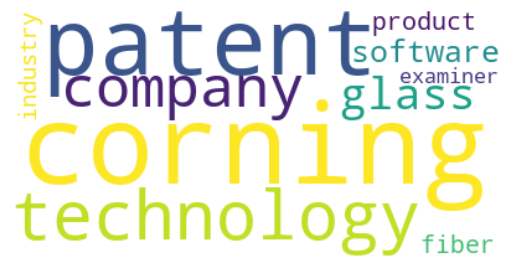

******************************
Topic: 16


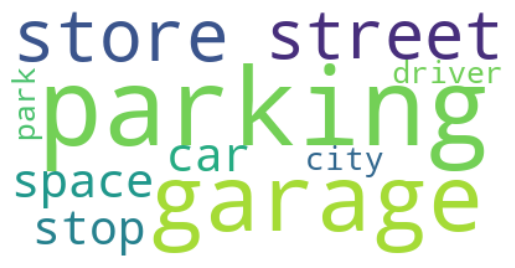

******************************
Topic: 17


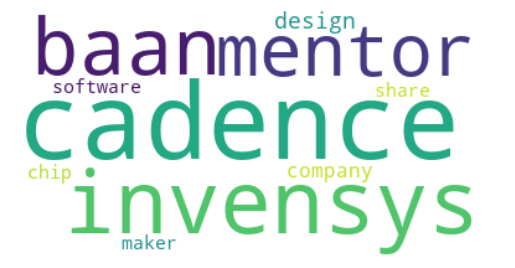

******************************
Topic: 18


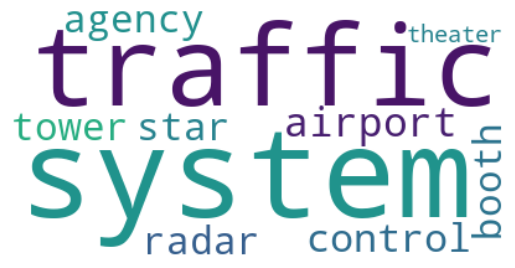

******************************


In [134]:
# word cloud for each topic
for i in range(len(topic_model.get_topics())):
    print('Topic: ' + str(i-1))
    get_topic_word_cloud(topic_model, i-1)
    print('******************************')

In [135]:
# heirarchical topics
fig = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
fig.write_html(folder_path+'2000_2009/Hierarchical_Clustering.html')

In [136]:
# topic tree
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

.
├─company_system_technology_software_percent
│    ├─company_technology_system_software_computer
│    │    ├─health_drug_technology_company_care
│    │    │    ├─■──health_drug_care_patient_doctor ── Topic: 5
│    │    │    └─■──corning_patent_technology_company_glass ── Topic: 15
│    │    └─company_system_software_technology_computer
│    │         ├─job_economy_work_economic_worker
│    │         │    ├─■──container_card_technology_computer_punch ── Topic: 11
│    │         │    └─■──job_economy_work_economic_worker ── Topic: 2
│    │         └─company_system_software_computer_service
│    │              ├─■──airline_system_state_ticket_company ── Topic: 1
│    │              └─■──company_software_system_home_computer ── Topic: 0
│    └─exchange_stock_trading_company_fund
│         ├─■──fund_loan_percent_stock_money ── Topic: 7
│         └─exchange_trading_stock_company_bank
│              ├─■──company_dormann_billion_executive_business ── Topic: 4
│              └─■──exchange_trad

In [140]:
# need embeddings
fig = topic_model.visualize_hierarchical_documents(docs, hierarchical_topics, embeddings=embeddings)
fig.write_html(folder_path+'2000_2009/Heirarchical_Docs_Topics.html')

In [141]:
# topic similarity
fig = topic_model.visualize_heatmap()
fig.write_html(folder_path+'2000_2009/Heatmap.html')

In [142]:
# if we keep adding words to topic name how score decreases
fig = topic_model.visualize_term_rank()
fig.write_html(folder_path+'2000_2009/Term_Score_Decline.html')

In [143]:
topic_model.visualize_term_rank(log_scale=True)
fig.write_html(folder_path+'2000_2009/Term_Score_Decline_log_scale.html')

### 2010 - 2019

In [144]:
output = r"/Users/vedantgupta/Desktop/Oncampus - Research/nyt-topic-modeling-main/Topic Modeling Code/BERT/BERT/2010-2019/"

In [145]:
topic_model = BERTopic.load(output+"bert")
with open(output+'hierarchical_topics.pkl', 'rb') as f:
    hierarchical_topics = pickle.load(f)
with open(output+'docs.pkl', 'rb') as f:
    docs = pickle.load(f)
with open(output+'embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

In [146]:
topic_model.get_topics()

{-1: [('company', 0.02156707886615352),
  ('people', 0.01685671388640333),
  ('worker', 0.015480308631717943),
  ('percent', 0.015122033333975887),
  ('work', 0.014362040290851624),
  ('job', 0.014168691817063222),
  ('business', 0.012296346076408114),
  ('trump', 0.011713744306052768),
  ('technology', 0.011619932448233967),
  ('also', 0.011479482858358113)],
 0: [('company', 0.019941462290457988),
  ('people', 0.014238361016159749),
  ('state', 0.01291470545224444),
  ('technology', 0.012398465891951293),
  ('also', 0.012324388141455892),
  ('work', 0.012280731086186268),
  ('worker', 0.011282228661776214),
  ('many', 0.011125289336672759),
  ('make', 0.01078733401824957),
  ('percent', 0.01070239923008508)],
 1: [('pilot', 0.10075036795551134),
  ('boeing', 0.08575966814920614),
  ('plane', 0.07118872907017161),
  ('flight', 0.06324197599978111),
  ('airline', 0.04715489361221815),
  ('crash', 0.04626764595988002),
  ('system', 0.038707161294923145),
  ('safety', 0.03716924639179152

In [147]:
# listing all topics
for i in range(len(topic_model.get_topics())+1):
    print("Topic "+ str(i-1) + ":")
    print()
    print("Representative Words:")
    print(topic_model.get_topic(i-1))
    print()
    print("Topic Info:")
    print(topic_model.get_topic_info(i-1))
    print()

Topic -1:

Representative Words:
[('company', 0.02156707886615352), ('people', 0.01685671388640333), ('worker', 0.015480308631717943), ('percent', 0.015122033333975887), ('work', 0.014362040290851624), ('job', 0.014168691817063222), ('business', 0.012296346076408114), ('trump', 0.011713744306052768), ('technology', 0.011619932448233967), ('also', 0.011479482858358113)]

Topic Info:
   Topic  Count                              Name
0     -1    559  -1_company_people_worker_percent

Topic 0:

Representative Words:
[('company', 0.019941462290457988), ('people', 0.014238361016159749), ('state', 0.01291470545224444), ('technology', 0.012398465891951293), ('also', 0.012324388141455892), ('work', 0.012280731086186268), ('worker', 0.011282228661776214), ('many', 0.011125289336672759), ('make', 0.01078733401824957), ('percent', 0.01070239923008508)]

Topic Info:
   Topic  Count                                  Name
0     -1    559      -1_company_people_worker_percent
1      0   2066     0_comp

In [149]:
# Topic distance map
fig = topic_model.visualize_topics()
fig.write_html(folder_path+'2010_2019/Intertopic_Distance_Map.html')

In [150]:
# representative words with probability for each topic
fig = topic_model.visualize_barchart(top_n_topics=len(topic_model.get_topics()))
fig.write_html(folder_path+'2010_2019/Topic_Word_Score.html')

In [151]:
fig = topic_model.visualize_documents(docs=docs, embeddings=embeddings)
fig.write_html(folder_path+'2010_2019/Docs_Topics.html')

In [152]:
#Applying TSNE to reduce embeddings
from sklearn.manifold import TSNE

reduced_embed = TSNE(n_components=10, learning_rate='auto', perplexity=30, method='exact').fit_transform(embeddings)

In [153]:
fig = topic_model.visualize_documents(docs=docs, embeddings=reduced_embed)
fig.write_html(folder_path+'2010_2019/Docs_Topics_TSNE.html')

In [154]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def get_topic_word_cloud(topic_model, topic_number):
    word_freq = topic_model.get_topic(topic_number)
    word_freq = {w:f for w, f in word_freq}
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color='white')
    wordcloud.generate_from_frequencies(word_freq)
    wordcloud.to_file(folder_path+'Topic_'+str(topic_number)+'_wordclound.png')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Topic: -1


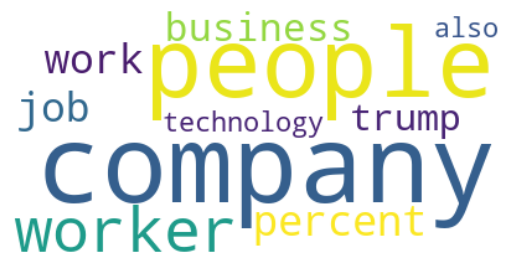

******************************
Topic: 0


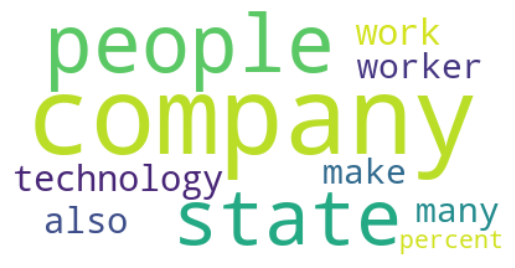

******************************
Topic: 1


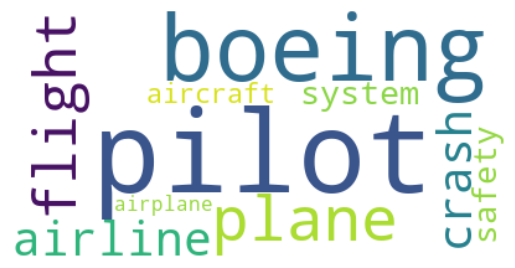

******************************
Topic: 2


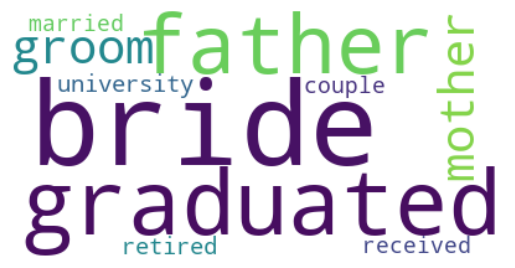

******************************
Topic: 3


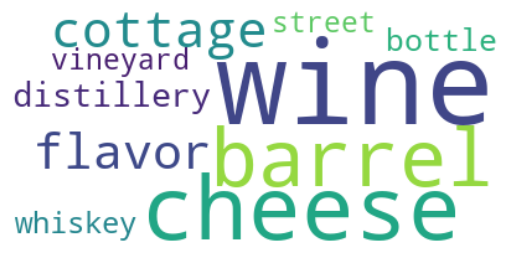

******************************
Topic: 4


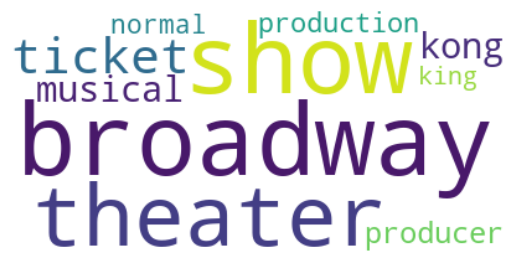

******************************
Topic: 5


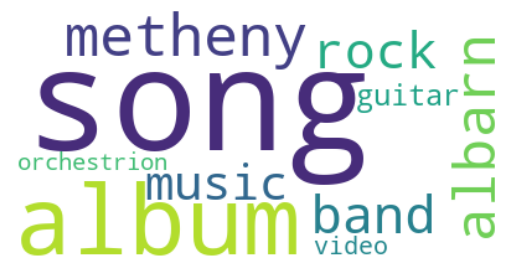

******************************
Topic: 6


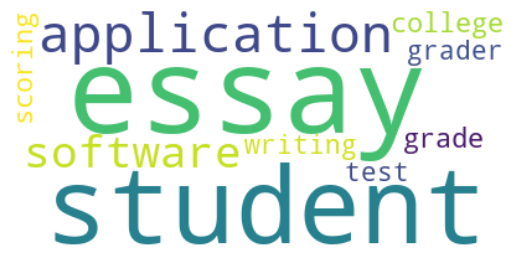

******************************
Topic: 7


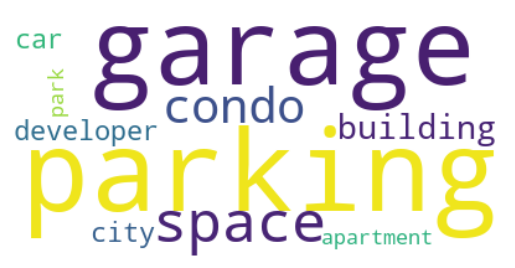

******************************


In [155]:
# word cloud for each topic
for i in range(len(topic_model.get_topics())):
    print('Topic: ' + str(i-1))
    get_topic_word_cloud(topic_model, i-1)
    print('******************************')

In [156]:
# heirarchical topics
fig = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
fig.write_html(folder_path+'2010_2019/Heirarchical_Clustering.html')

In [125]:
# topic tree
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

.
├─song_show_broadway_theater_musical
│    ├─■──song_album_metheny_albarn_band ── Topic: 5
│    └─■──broadway_show_theater_ticket_musical ── Topic: 4
└─company_people_state_also_technology
     ├─bride_graduated_father_university_groom
     │    ├─■──bride_graduated_father_groom_mother ── Topic: 2
     │    └─■──essay_student_application_software_college ── Topic: 6
     └─company_people_state_also_technology
          ├─company_people_state_also_technology
          │    ├─company_people_state_also_technology
          │    │    ├─■──pilot_boeing_plane_flight_airline ── Topic: 1
          │    │    └─■──company_people_state_technology_also ── Topic: 0
          │    └─■──wine_cheese_barrel_cottage_flavor ── Topic: 3
          └─■──parking_garage_space_condo_building ── Topic: 7



In [157]:
# topic similarity
fig = topic_model.visualize_heatmap()
fig.write_html(folder_path+'2010_2019/Heatmap.html')

In [158]:
# if we keep adding words to topic name how score decreases
fig = topic_model.visualize_term_rank()
fig.write_html(folder_path+'2010_2019/Term_Score_Decline.html')

In [159]:
fig = topic_model.visualize_term_rank(log_scale=True)
fig.write_html(folder_path+'2010_2019/Term_Score_Decline_log_scale.html')